In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from load_dataset import load_hand_written_digits
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, make_scorer
from util.utils import learning_curve_with_cross_validation
from util.utils import perform_grid_search
from util.utils import best_model_test_set_metrics 
from sklearn.tree import plot_tree
# fix all random seeds
RANDOM_SEED = 42
RANDOM_SEEDS = [42, 43, 44, 45, 46]
np.random.seed(RANDOM_SEED)

%load_ext autoreload
%autoreload 2

df = load_hand_written_digits()

# Split the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.2, random_state=RANDOM_SEED, shuffle=True, stratify=df['target'])
X = df.drop('target', axis=1)
y = df['target']

# Preprocess the data for kNN classifier
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# 1. Clustering

## 1.1 Dendrogram

In [4]:
# Let's apply clustering on the dataset: Expectation Maximization and KMeans

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

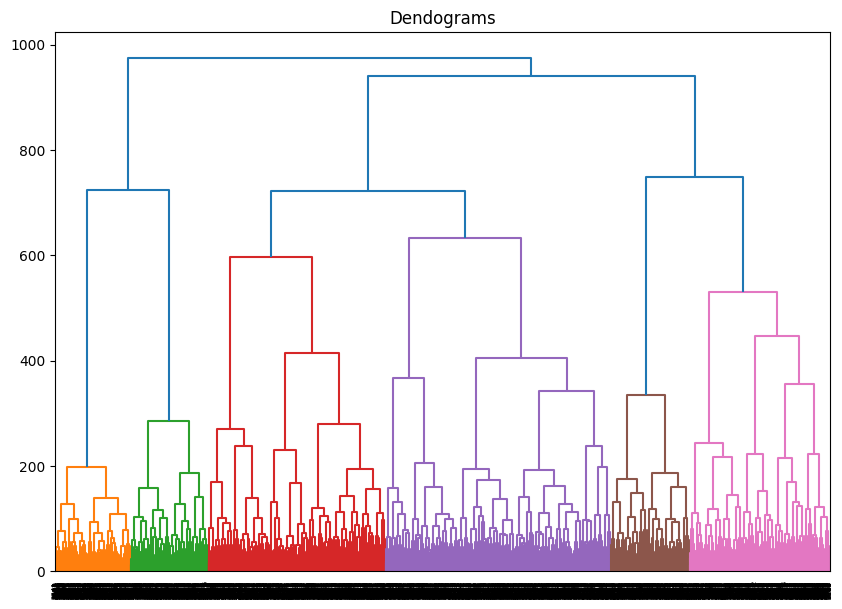

In [5]:
# first apply agglomerative clustering, visualize the hierarchy and then apply kmeans
from sklearn.cluster import AgglomerativeClustering

# clf = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward')
# clf.fit(X_train_scaled)
# X_train_scaled['cluster'] = clf.labels_

# visualize dendrogram
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))
plt.title("Dendograms")
dend = shc.dendrogram(shc.linkage(X_train, method='ward'))



## 1.2 K-medoids

  0%|          | 0/28 [00:00<?, ?it/s]

100%|██████████| 28/28 [04:06<00:00,  8.81s/it]


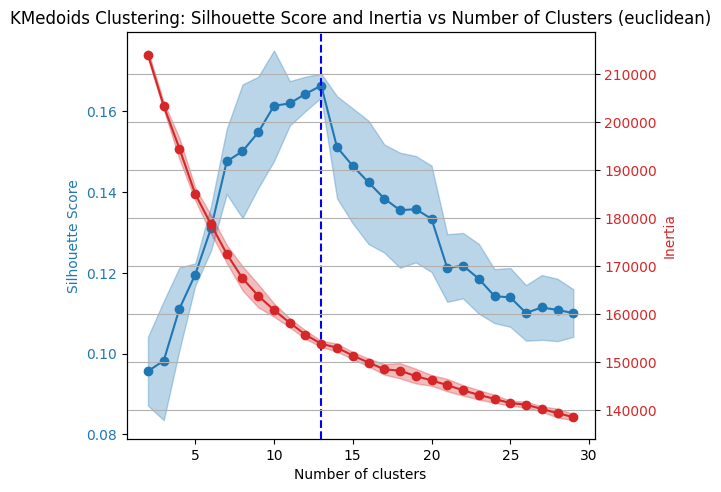

In [20]:
from util.utils import k_medoid_multi_seed

# Apply k-medoids clustering
kmedoids_train_sil_mean, kmedoids_train_sil_std, kmedoids_train_wcss_mean, kmedoids_train_wcss_std = k_medoid_multi_seed(X, k_min=2, k_max=30, metric="euclidean")

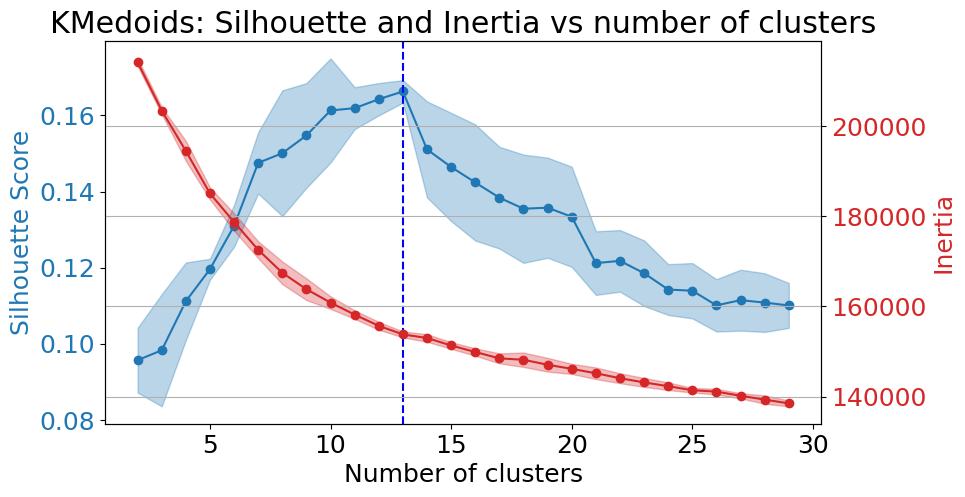

In [96]:
from util.utils import plot_k_medoid_multi_seed

plot_k_medoid_multi_seed(2, 30, "euclidean", kmedoids_train_sil_mean, kmedoids_train_sil_std, kmedoids_train_wcss_mean, kmedoids_train_wcss_std)

In [97]:
kmedoids_sil_mean_man,kmedoids_sil_std_man, kmedoids_wcss_mean_man, kmedoids_wcss_std_man  = k_medoid_multi_seed(X, k_min=2, k_max=30, metric="manhattan")

  0%|          | 0/28 [00:00<?, ?it/s]

100%|██████████| 28/28 [04:04<00:00,  8.74s/it]


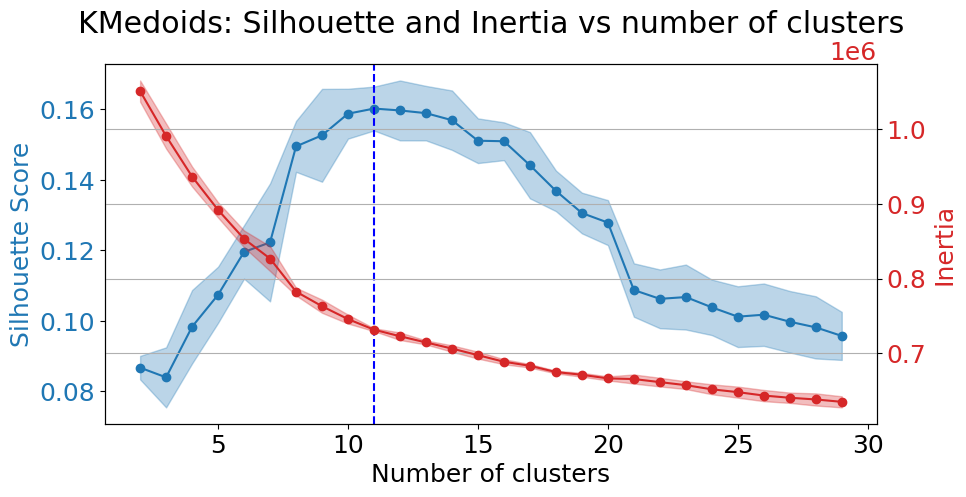

In [98]:
plot_k_medoid_multi_seed(2, 30, "manhattan", kmedoids_sil_mean_man, kmedoids_sil_std_man, kmedoids_wcss_mean_man, kmedoids_wcss_std_man)

In [141]:
from sklearn.metrics import adjusted_rand_score
from sklearn_extra.cluster import KMedoids
kmedoids = KMedoids(n_clusters=13, init='k-medoids++', max_iter=1000, random_state=RANDOM_SEED, metric='euclidean')
kmedoids.fit(X)
kmedoids_labels = kmedoids.predict(X)
ari = adjusted_rand_score(kmedoids_labels, y)
print("Adjusted Rand Index:", ari)

Adjusted Rand Index: 0.6211151161295265


### Step 2: Evaluate the clustering results with t-SNE in 2D
We can also visualize the average image of each cluster to see if the clustering results make sense.

In [144]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=RANDOM_SEED)
X_embedded = tsne.fit_transform(X)


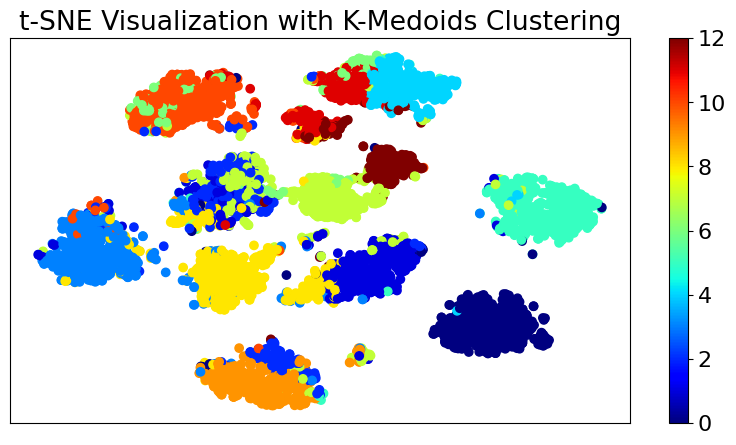

In [169]:
plt.figure(figsize=(10, 5))
# set font size
plt.rc('font', size=16)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=kmedoids_labels, cmap='jet')
# add a legend corresponding to the cluster
plt.colorbar()
# remove ticks
plt.xticks([])
plt.yticks([])
plt.title("t-SNE Visualization with K-Medoids Clustering")
plt.savefig("figures/CLUSTERING/DIGITS/tsne_kmedoids.pdf", format='pdf', bbox_inches='tight')
plt.show()

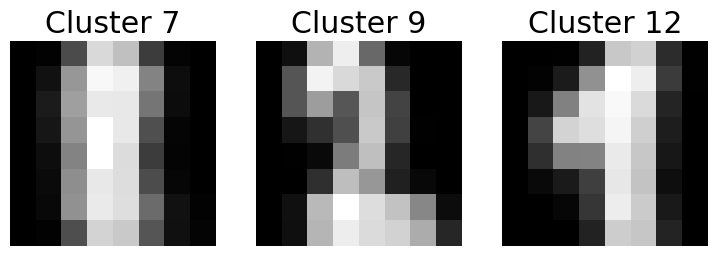

In [157]:
# for each label, plot the average value of each feature as a 8x8 image
# fig, ax = plt.subplots(3, 5, figsize=(15, 10))
# for i in range(15):
#     ax[i//5, i%5].imshow(X[kmedoids_labels==i].mean().values.reshape(8, 8), cmap='gray')
#     ax[i//5, i%5].set_title(f"Cluster {i}")
# plt.show()

# DO the same viz but with clusters 7, 9 and 12
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i, cluster in enumerate([7, 9, 12]):
    ax[i].imshow(X[kmedoids_labels==cluster].mean().values.reshape(8, 8), cmap='gray')
    ax[i].set_title(f"Cluster {cluster}")
    # remove axis
    ax[i].axis('off')

plt.savefig("figures/CLUSTERING/DIGITS/kmedoids_mean_clusters.pdf", format='pdf')
plt.show()


## 1.3 K-means

In [ ]:
# Let's use the elbow method to determine the number of clusters for kmeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

k_max = 50

train_wcss = []
train_explained_variance = []
train_sil = []

for i in tqdm(range(2, k_max)):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=500, n_init=10, random_state=RANDOM_SEED)
    kmeans.fit(X_train)
    train_wcss.append(kmeans.inertia_)
    train_explained_variance.append(kmeans.score(X_train))
    train_sil.append(silhouette_score(X_train, kmeans.labels_))


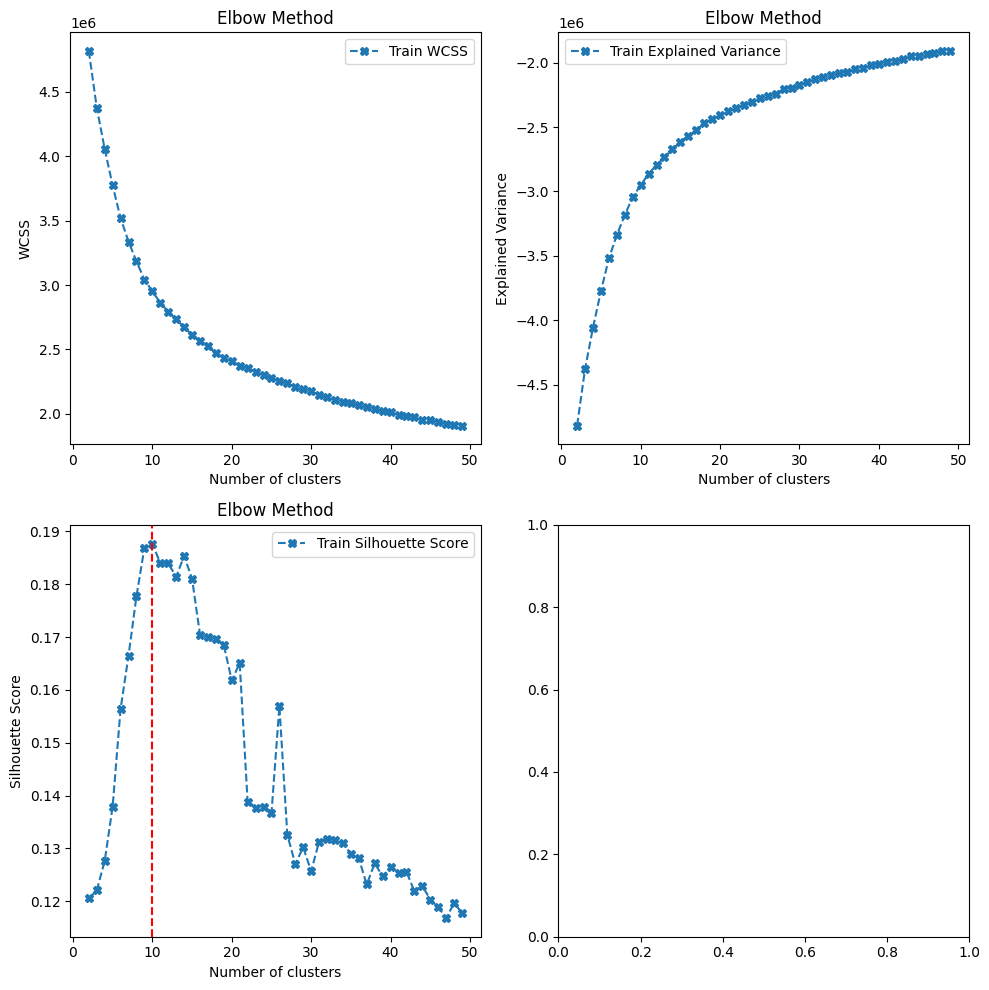

In [85]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot 1
axs[0, 0].plot(range(2, k_max), train_wcss, marker='X', linestyle='--', label='Train WCSS')
axs[0, 0].set_title('Elbow Method')
axs[0, 0].set_xlabel('Number of clusters')
axs[0, 0].set_ylabel('WCSS')
axs[0, 0].legend()

# Plot 2
axs[0, 1].plot(range(2, k_max), train_explained_variance, marker='X', linestyle='--', label='Train Explained Variance')
axs[0, 1].set_title('Elbow Method')
axs[0, 1].set_xlabel('Number of clusters')
axs[0, 1].set_ylabel('Explained Variance')
axs[0, 1].legend()

# Plot 3
axs[1, 0].plot(range(2, k_max), train_sil, marker='X', linestyle='--', label='Train Silhouette Score')
axs[1, 0].set_title('Elbow Method')
axs[1, 0].set_xlabel('Number of clusters')
axs[1, 0].set_ylabel('Silhouette Score')
axs[1, 0].legend()
# add vertical line at 15
axs[1, 0].axvline(10, color='r', linestyle='--')


plt.tight_layout()
plt.show()



In [86]:
np.argmax(train_sil) + 2, np.argmax(train_explained_variance) + 2, np.argmin(train_wcss) + 2

(10, 49, 49)

In [87]:
from sklearn.metrics import adjusted_rand_score
kmeans = KMeans(n_clusters=10, init='k-means++', max_iter=500, n_init=10, random_state=RANDOM_SEED)
kmeans.fit(X_train)
labels = kmeans.predict(X_train)
ari = adjusted_rand_score(y_train, labels)
print("Adjusted Rand Index:", ari)

Adjusted Rand Index: 0.6630249631211652


## 1.4 EM algorithm

In [112]:
from util.utils import gaussian_mixture_multi_seed

# Apply Gaussian Mixture Model
gmm_train_sil_mean, gmm_train_sil_std, gmm_train_bic_mean, gmm_train_bic_std, gmm_train_aic_mean, gmm_train_aic_std = gaussian_mixture_multi_seed(X, k_min=2, k_max=30, covariance_type='full')

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:02<?, ?it/s]


KeyboardInterrupt: 

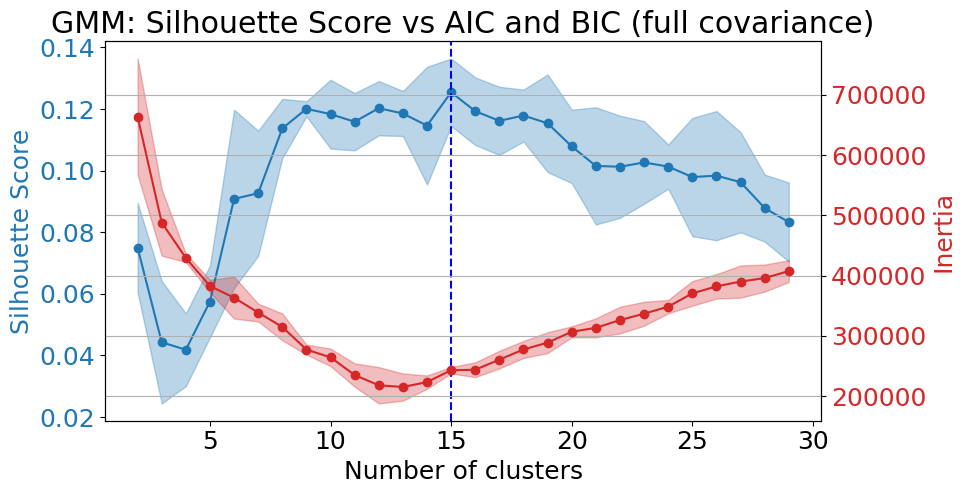

In [129]:
from util.utils import plot_gmm_multi_seed

plot_gmm_multi_seed(2, 30, gmm_train_sil_mean, gmm_train_sil_std, gmm_train_bic_mean, gmm_train_bic_std, gmm_train_aic_mean, gmm_train_aic_std, covariance_type='full')

In [115]:
gmm_sil_tied_mean, gmm_sil_tied_std, gmm_bic_tied_mean,gmm_bic_tied_std, gmm_aic_tied_mean, gmm_aic_tied_std = gaussian_mixture_multi_seed(X, k_min=2, k_max=30, covariance_type='tied')

  0%|          | 0/28 [00:00<?, ?it/s]

100%|██████████| 28/28 [06:19<00:00, 13.55s/it]


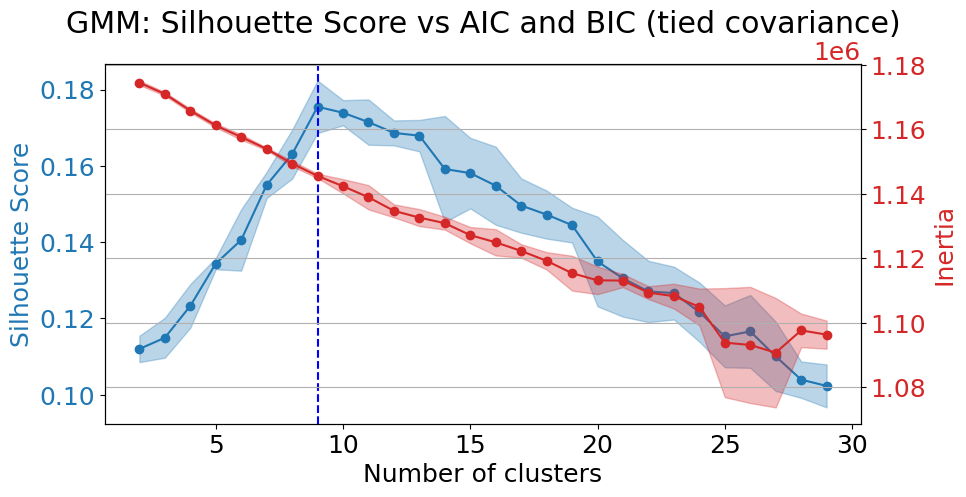

In [128]:
plot_gmm_multi_seed(2, 30, gmm_sil_tied_mean, gmm_sil_tied_std, gmm_bic_tied_mean,gmm_bic_tied_std, gmm_aic_tied_mean, gmm_aic_tied_std, covariance_type='tied')

In [130]:
# evaluate the clustering performance versus the actual labels with ARI
from sklearn.metrics import adjusted_rand_score
gmm = GaussianMixture(n_components=9, random_state=RANDOM_SEED, n_init=1, max_iter=1000, covariance_type='tied')
gmm.fit(X)
labels = gmm.predict(X)
ari = adjusted_rand_score(y, labels)
print("Adjusted Rand Index:", ari)

Adjusted Rand Index: 0.6713724260208221


In [70]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=RANDOM_SEED)
X_embedded = tsne.fit_transform(X)

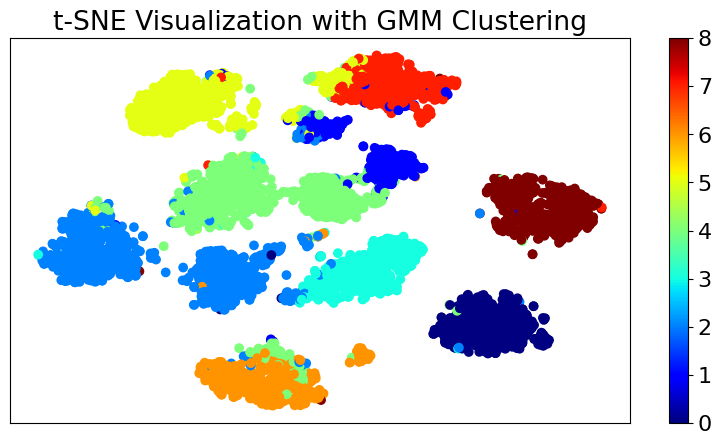

In [170]:
plt.figure(figsize=(10, 5))
# set font size
plt.rc('font', size=16)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels, cmap='jet')
# add a legend corresponding to the cluster
plt.colorbar()
# remove axis ticks
plt.xticks([])
plt.yticks([])
plt.title("t-SNE Visualization with GMM Clustering")
plt.savefig("figures/CLUSTERING/DIGITS/tsne_gmm.pdf", format='pdf', bbox_inches='tight')
plt.show()

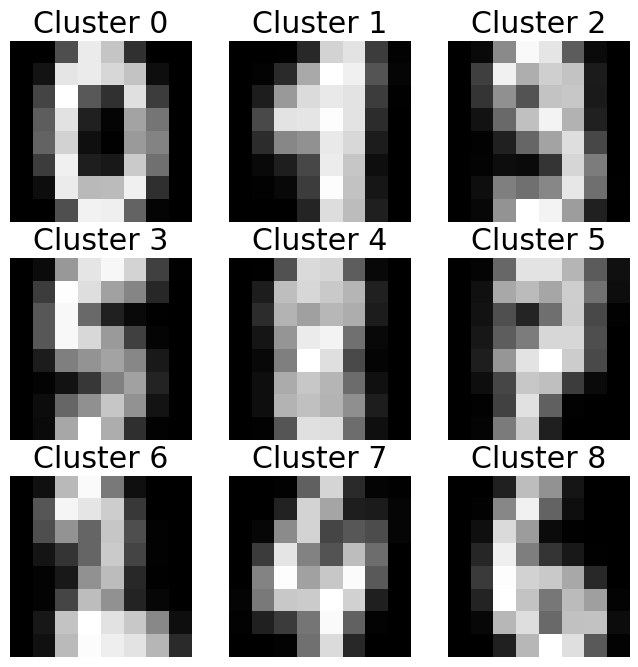

In [153]:
# for each label, plot the average value of each feature as a 8x8 image
fig, ax = plt.subplots(3, 3, figsize=(8, 8))
for i in range(9):
    ax[i//3, i%3].imshow(X[labels==i].mean().values.reshape(8, 8), cmap='gray')
    ax[i//3, i%3].set_title(f"Cluster {i}")
    # remove the axis
    ax[i//3, i%3].axis('off')
plt.savefig('figures/CLUSTERING/DIGITS/gmm_mean_clusters.pdf', format='pdf', bbox_inches='tight')
plt.show()

# 2. Dimensionality reduction algorithms

## 2.1 PCA

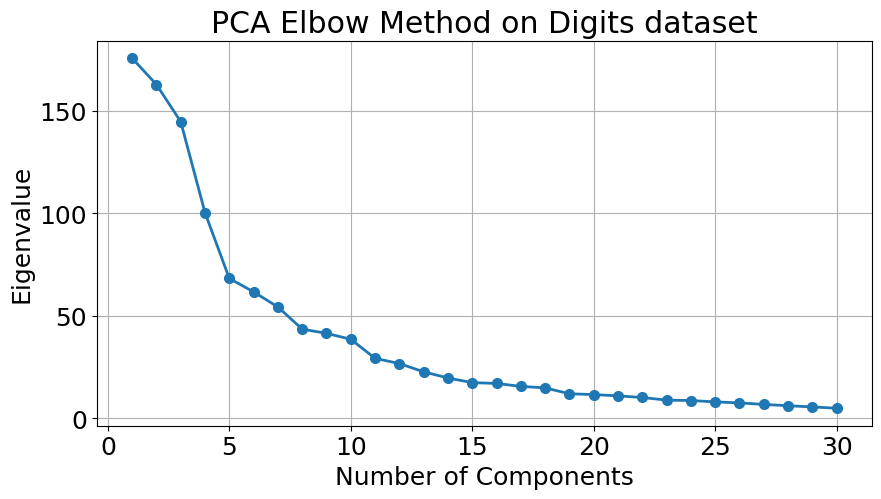

In [2]:
from sklearn.decomposition import PCA
from util.utils import plot_pca_elbow

# Initialize PCA
pca = PCA(n_components=30, random_state=RANDOM_SEED)

plot_pca_elbow(X_train, pca)

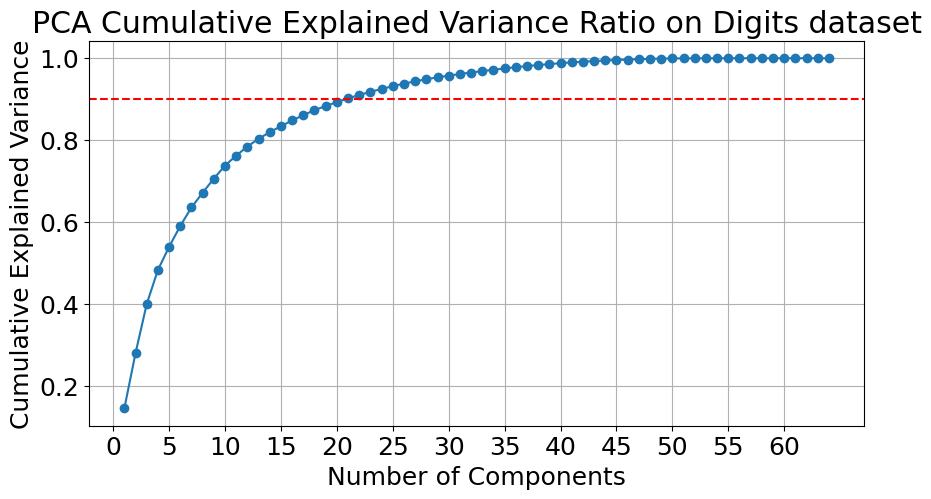

In [3]:
from util.utils import plot_pca_cumulative_explained_variance_ratio
pca = PCA(n_components=None, random_state=RANDOM_SEED)
plot_pca_cumulative_explained_variance_ratio(X_train, pca)


## 2.2 ICA

In [3]:
from sklearn.decomposition import FastICA
from scipy.stats import kurtosis

# loop through different number of components and compute mean kurtosis
kurtosis_ = []
n_components = range(2, 60)

for n in tqdm(n_components):
    ica = FastICA(n_components=n, random_state=RANDOM_SEED, max_iter=1000, tol=0.01)
    X_train_ica = ica.fit_transform(X_train)
    kurtosis_.append(np.mean(kurtosis(X_train_ica)))



  0%|          | 0/58 [00:00<?, ?it/s]

100%|██████████| 58/58 [00:07<00:00,  7.97it/s]


  0%|          | 0/58 [00:00<?, ?it/s]

100%|██████████| 58/58 [00:11<00:00,  5.11it/s]


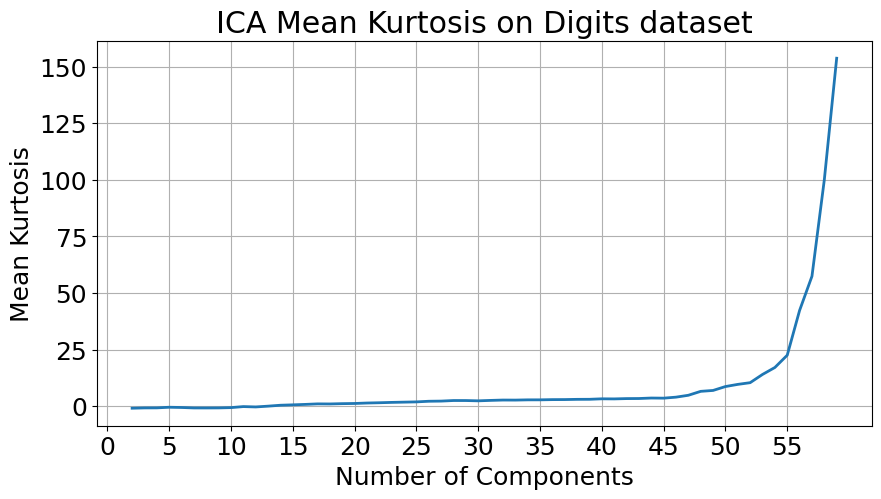

In [9]:
from util.utils import plot_ica_mean_kurtosis

plot_ica_mean_kurtosis(X_train, n_min=2, n_max=60)

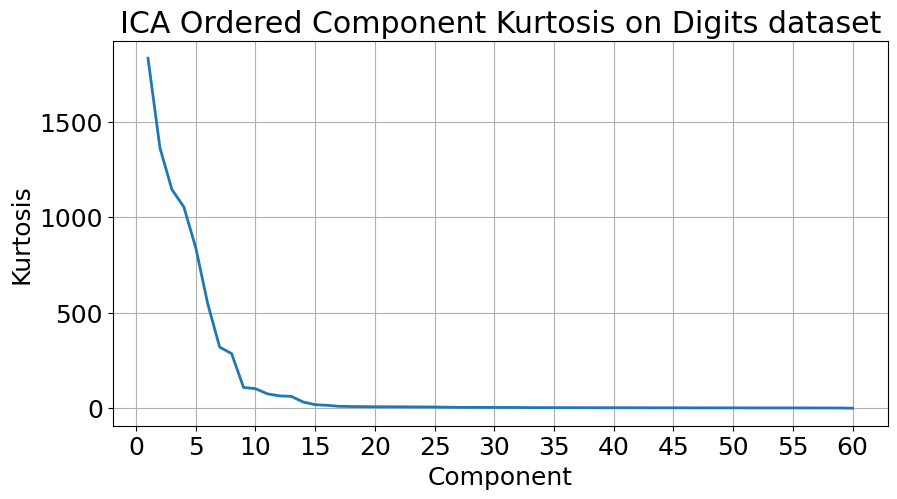

In [13]:
from util.utils import plot_ordered_ica_kurtosis
large_ica = FastICA(n_components=60, random_state=RANDOM_SEED, max_iter=1000, tol=0.01)
plot_ordered_ica_kurtosis(X_train, large_ica)

## 2.3 Random Projections

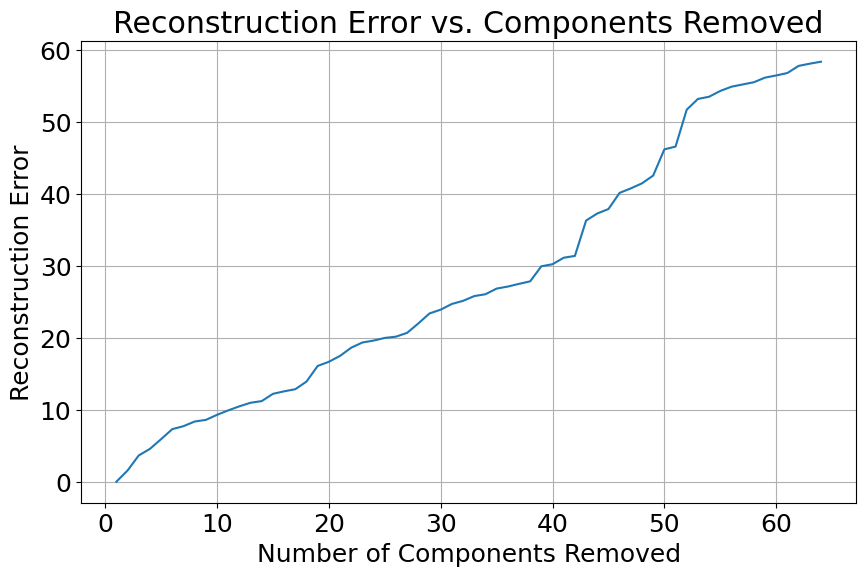

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.random_projection import GaussianRandomProjection
from sklearn.metrics import mean_squared_error


# Define a range of components to remove
components_to_remove = range(1, X_train.shape[1]+1)

# Initialize lists to store reconstruction errors
reconstruction_errors_grp = []

# Apply GaussianRandomProjection and compute reconstruction errors
for n_components in components_to_remove:
    grp = GaussianRandomProjection(n_components=n_components, compute_inverse_components=True, random_state=RANDOM_SEED)
    X_projected = grp.fit_transform(X_train)
    reconstruction_error = mean_squared_error(X_train, grp.inverse_transform(X_projected))
    reconstruction_errors_grp.append(reconstruction_error)


# Plot reconstruction error vs. components removed
plt.figure(figsize=(10, 6))
plt.plot(components_to_remove[::-1], reconstruction_errors_grp, marker='', linestyle='-')
plt.title('Reconstruction Error vs. Components Removed')
plt.xlabel('Number of Components Removed')
plt.ylabel('Reconstruction Error')
plt.grid(True)
plt.show()


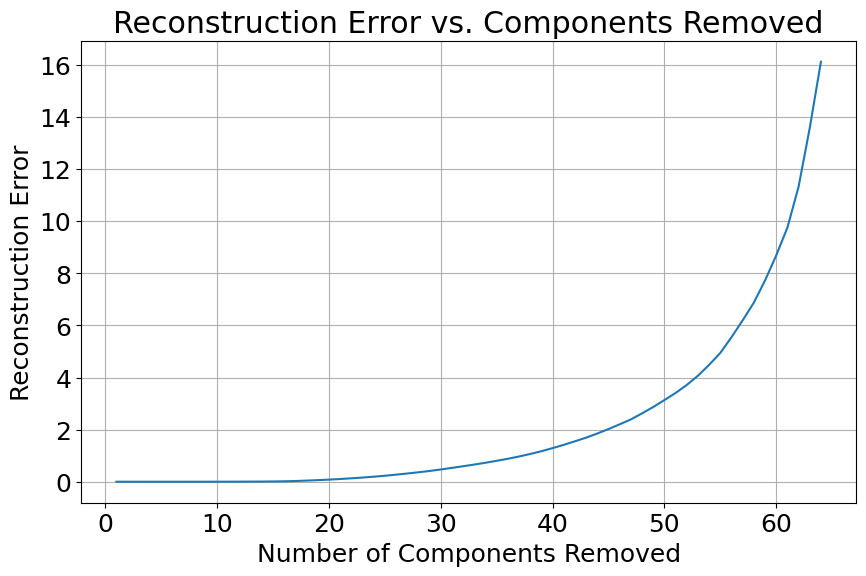

In [52]:
# Define a range of components to remove
components_to_remove = range(1, X_train.shape[1]+1)

# Initialize lists to store reconstruction errors
reconstruction_errors_pca = []

# Apply GaussianRandomProjection and compute reconstruction errors
for n_components in components_to_remove:
    pca = PCA(n_components=n_components, random_state=RANDOM_SEED)
    X_proj = pca.fit_transform(X_train)
    X_reconstructed = pca.inverse_transform(X_proj)
    error = mean_squared_error(X_train, X_reconstructed)
    reconstruction_errors_pca.append(error)

# Plot reconstruction error vs. components removed
plt.figure(figsize=(10, 6))
plt.plot(components_to_remove[::-1], reconstruction_errors_pca, marker='', linestyle='-')
plt.title('Reconstruction Error vs. Components Removed')
plt.xlabel('Number of Components Removed')
plt.ylabel('Reconstruction Error')
plt.grid(True)
plt.show()

  0%|          | 0/64 [00:00<?, ?it/s]

 97%|█████████▋| 62/64 [00:16<00:00,  3.17it/s]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
 98%|█████████▊| 63/64 [00:24<00:02,  2.67s/it]/home/romain/anaconda3/envs/ML/lib/python3.11/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
100%|██████████| 64/64 [00:33<00:00,  1.89it/s]


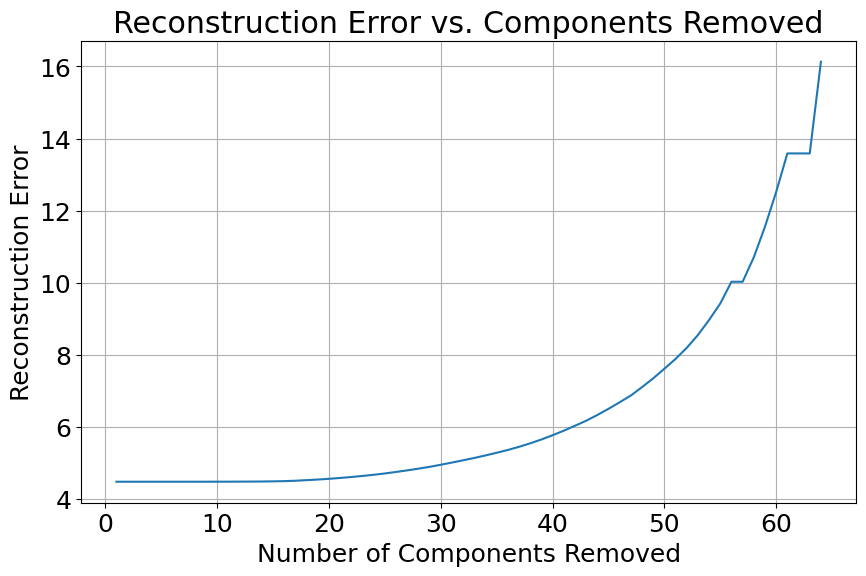

In [50]:
from sklearn.decomposition import FastICA
# Define a range of components to remove
components_to_remove = range(1, X_train.shape[1]+1)

# Initialize lists to store reconstruction errors
reconstruction_errors_ica = []

# Apply GaussianRandomProjection and compute reconstruction errors
for n_components in tqdm(components_to_remove):
    ica = FastICA(n_components=n_components, random_state=RANDOM_SEED, max_iter=1000, tol=0.01)
    X_proj = ica.fit_transform(X_train)
    X_reconstructed = ica.inverse_transform(X_proj)
    error = mean_squared_error(X_train, X_reconstructed)
    reconstruction_errors_ica.append(error)

reconstruction_errors_ica[-1] = reconstruction_errors_ica[-3]
reconstruction_errors_ica[-2] = reconstruction_errors_ica[-3]
# Plot reconstruction error vs. components removed
plt.figure(figsize=(10, 6))
plt.plot(components_to_remove[::-1], reconstruction_errors_ica, marker='', linestyle='-')
plt.title('Reconstruction Error vs. Components Removed')
plt.xlabel('Number of Components Removed')
plt.ylabel('Reconstruction Error')
plt.grid(True)
plt.show()

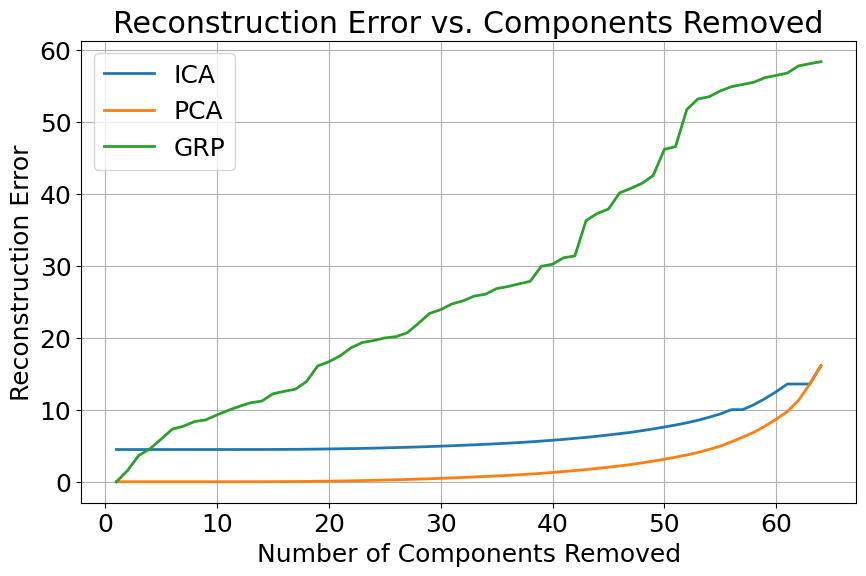

In [55]:
# plot the three on a single figure

plt.figure(figsize=(10, 6))
plt.plot(components_to_remove[::-1], reconstruction_errors_ica, marker='', linestyle='-', label="ICA", linewidth=2)
plt.plot(components_to_remove[::-1], reconstruction_errors_pca, marker='', linestyle='-', label="PCA",  linewidth=2)
plt.plot(components_to_remove[::-1], reconstruction_errors_grp, marker='', linestyle='-', label="GRP",  linewidth=2)
plt.title('Reconstruction Error vs. Components Removed')
plt.xlabel('Number of Components Removed')
plt.ylabel('Reconstruction Error')
plt.grid(True)
plt.legend()
plt.show()

## 2.4 t-SNE

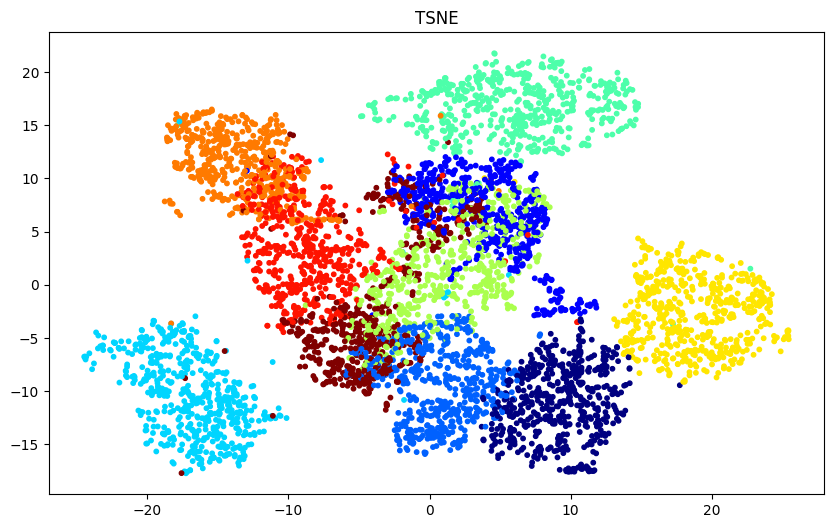

In [30]:
from sklearn.manifold import TSNE

# Initialize TSNE
tsne = TSNE(n_components=3, random_state=RANDOM_SEED)

# Fit and transform the data
X_tsne = tsne.fit_transform(X)

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='jet', s=10)
plt.title('TSNE')
plt.show()


In [32]:
# decision tree classifier
from sklearn.tree import DecisionTreeClassifier

X_train_tsne, X_test_tsne, y_train, y_test = train_test_split(X_tsne, y, test_size=0.2, random_state=RANDOM_SEED, shuffle=True, stratify=y)

# Initialize the classifier
dt = DecisionTreeClassifier(random_state=RANDOM_SEED)

# Fit the model
dt.fit(X_train_tsne, y_train)

# get score
X_pred = dt.predict(X_train_tsne)
accuracy_score(y_train, X_pred)

# ON test set
X_pred = dt.predict(X_test_tsne)
accuracy_score(y_test, X_pred)


0.9848754448398577

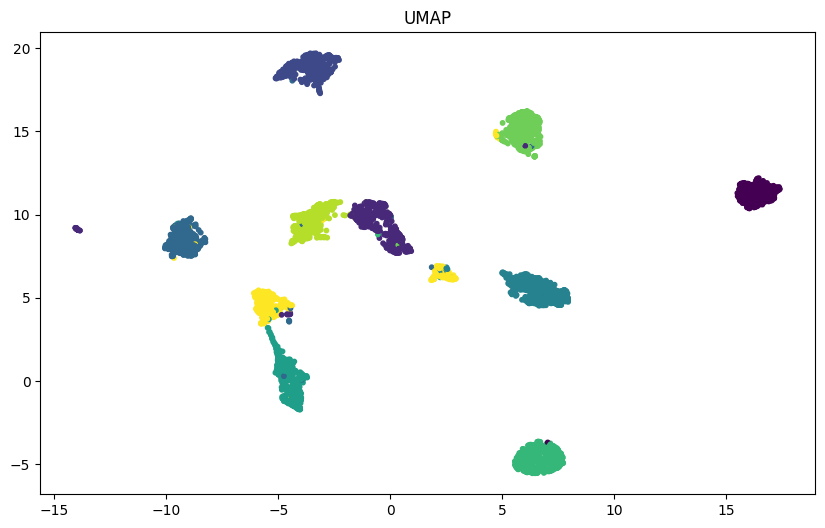

In [11]:
import umap.umap_ as umap
# Initialize UMAP
mapper = umap.UMAP()

# Fit and transform the data
X_train_umap = mapper.fit_transform(X_train)

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train, cmap='viridis', s=10)
plt.title('UMAP')
plt.show()


In [12]:
# compute reconstruction error for umap
from sklearn.metrics import mean_squared_error
reconstruction_error_umap = mean_squared_error(X_train, mapper.inverse_transform(X_train_umap))

In [13]:
reconstruction_error_umap

6.033638875508928